In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/manish-kc-06/test/refs/heads/main/Q1_2021_1_min_data.csv?token=GHSAT0AAAAAADITMBH2ZF2JL3X7YWPCSALC2FLPFKA")

In [4]:
df.head()

ticker        date      time    open    high     low   close  volume
0  ADANIENT  2021-02-01  09:15:00  510.50  510.95  507.05  509.35   84800
1  ADANIENT  2021-02-01  09:16:00  509.70  511.00  507.10  508.85   45106
2  ADANIENT  2021-02-01  09:17:00  508.85  510.00  508.30  508.85   28925
3  ADANIENT  2021-02-01  09:18:00  509.00  509.85  506.00  506.00   58143
4  ADANIENT  2021-02-01  09:19:00  505.95  506.75  500.55  501.10   65530

In [5]:
# Combine into one 'datetime' column
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
df.sort_values(['ticker', 'datetime'], inplace=True)

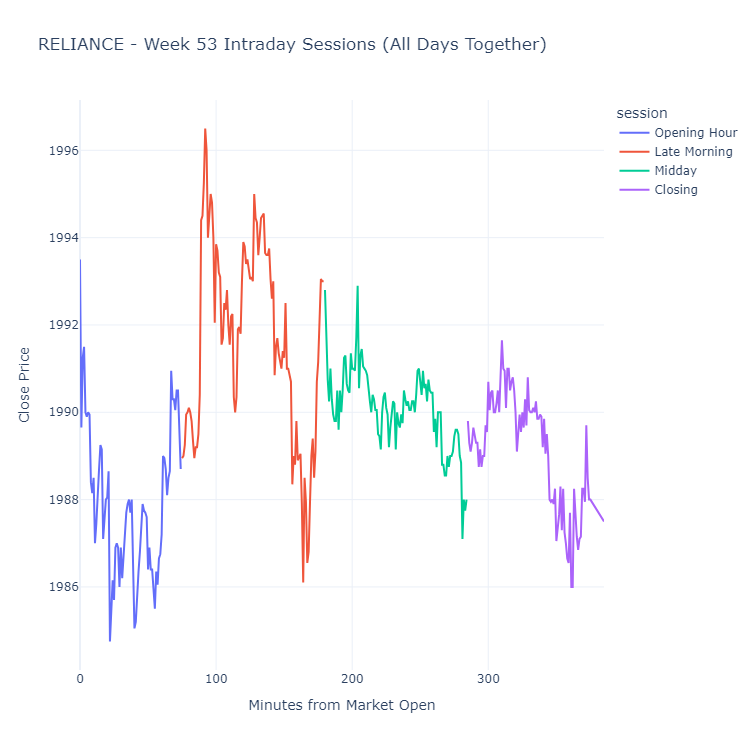

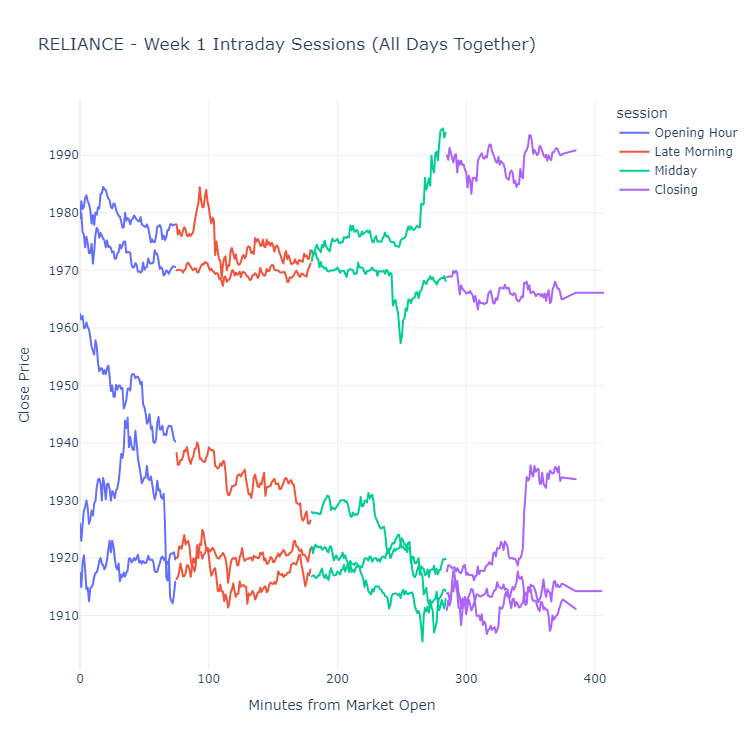

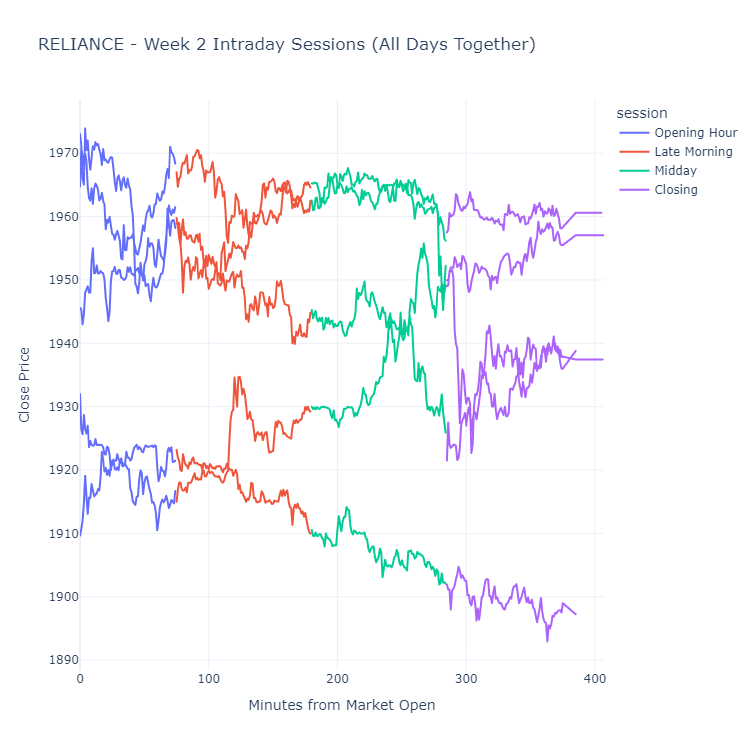

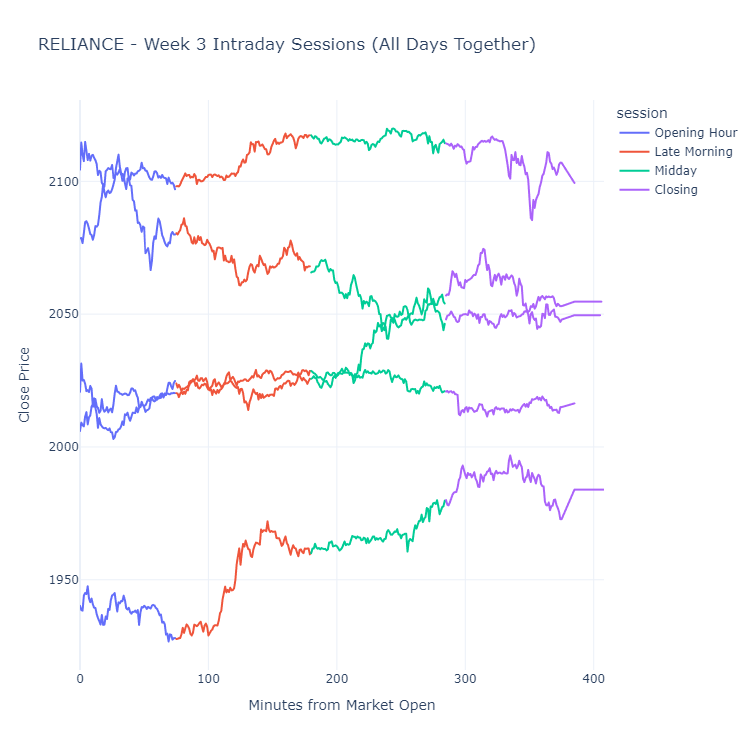

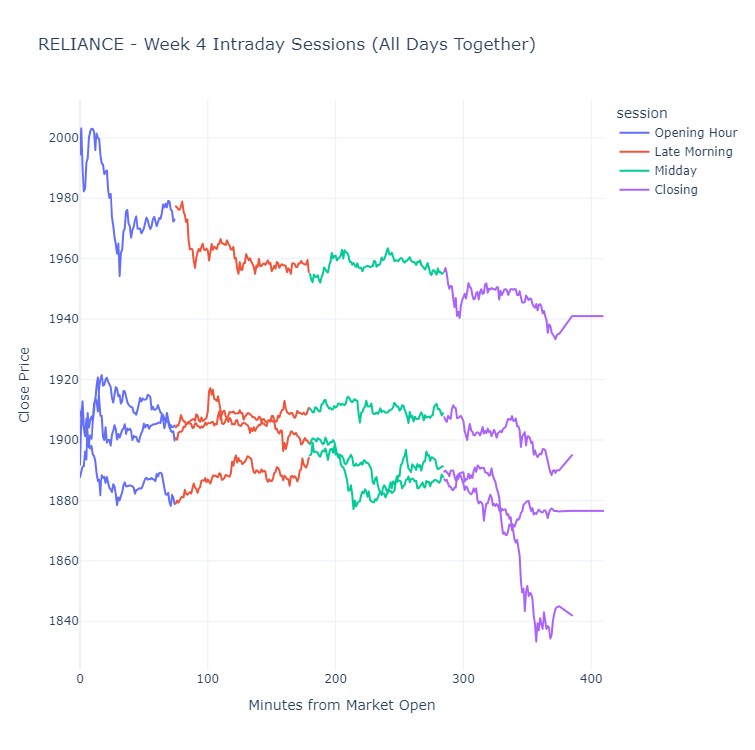

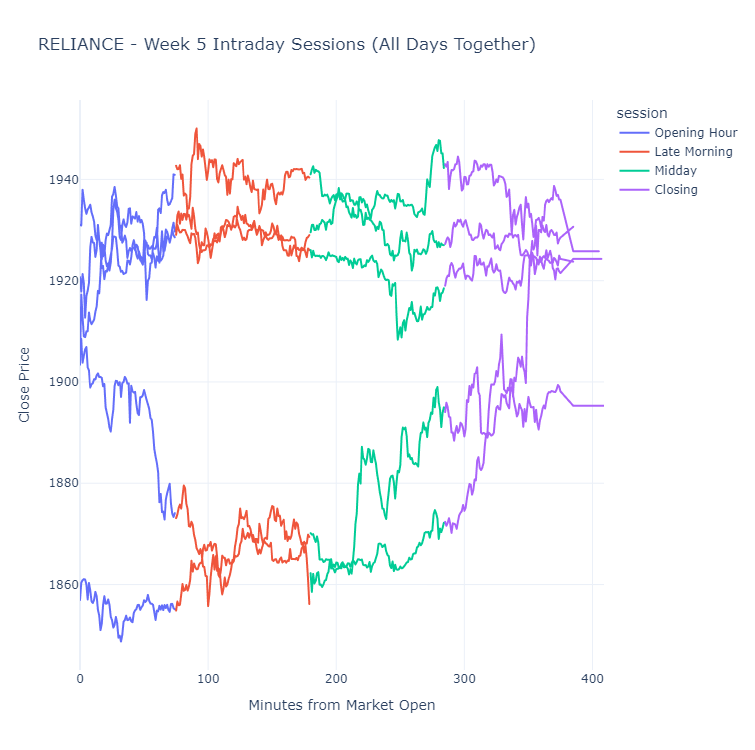

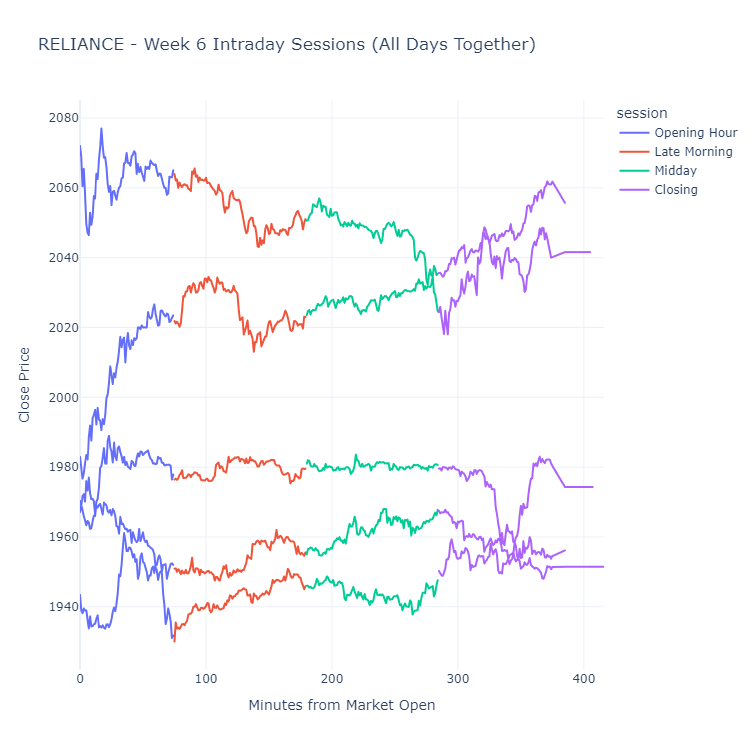

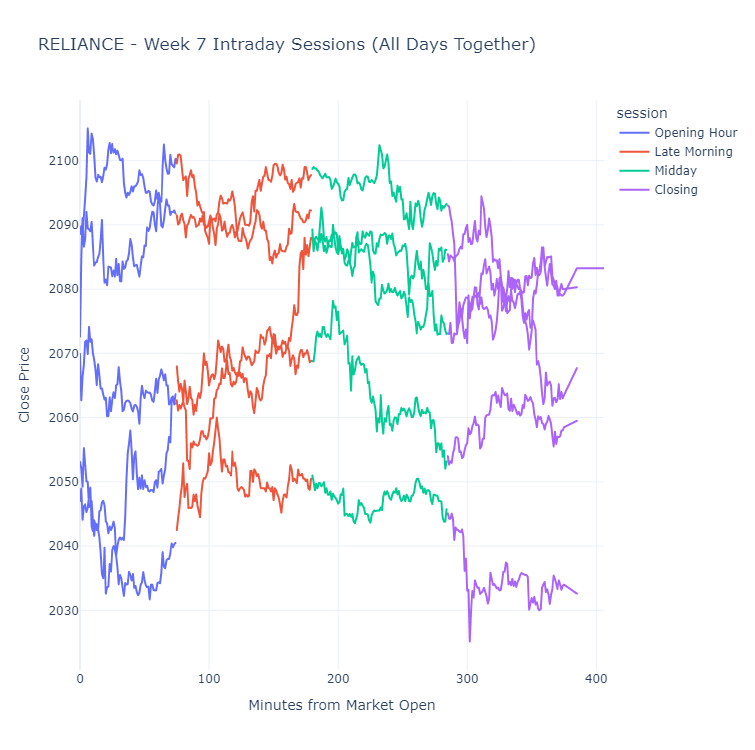

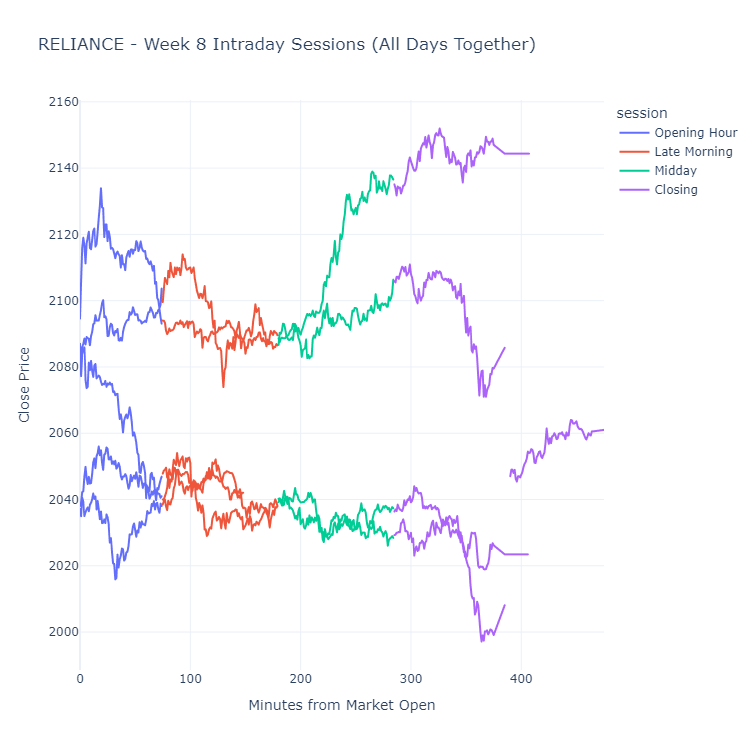

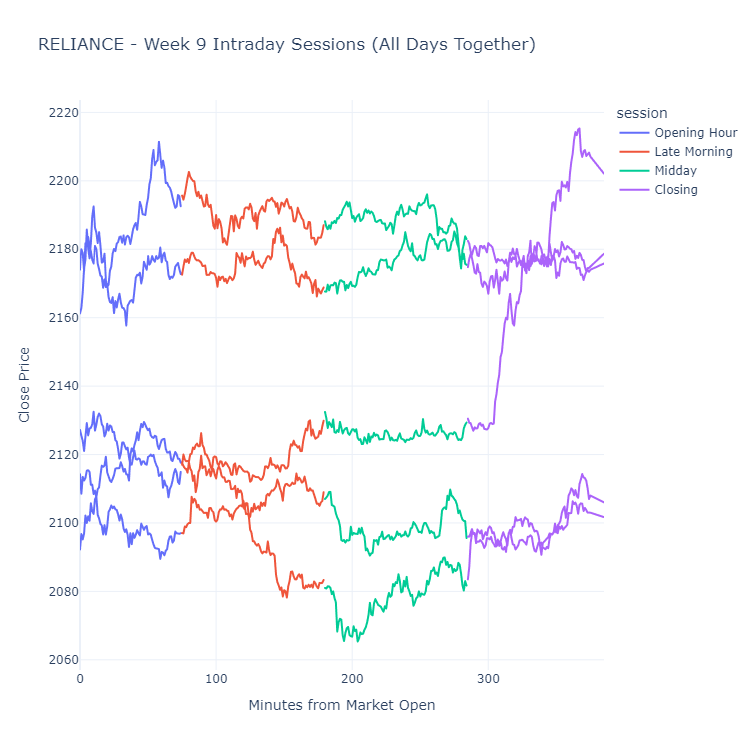

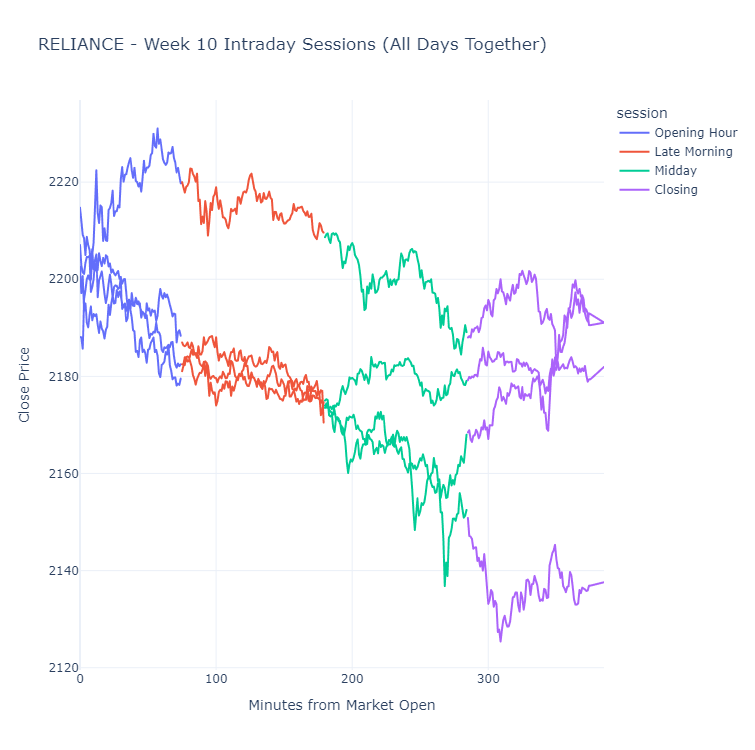

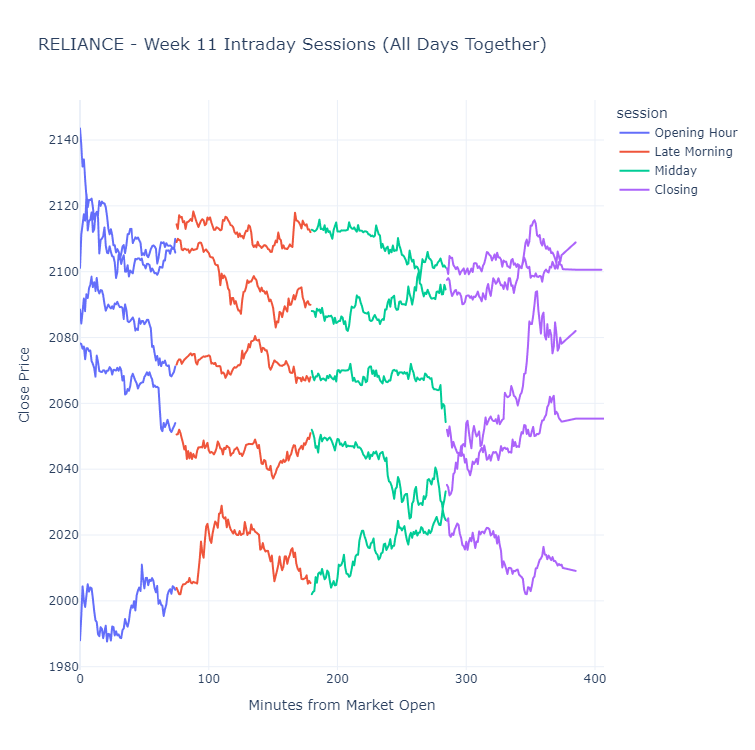

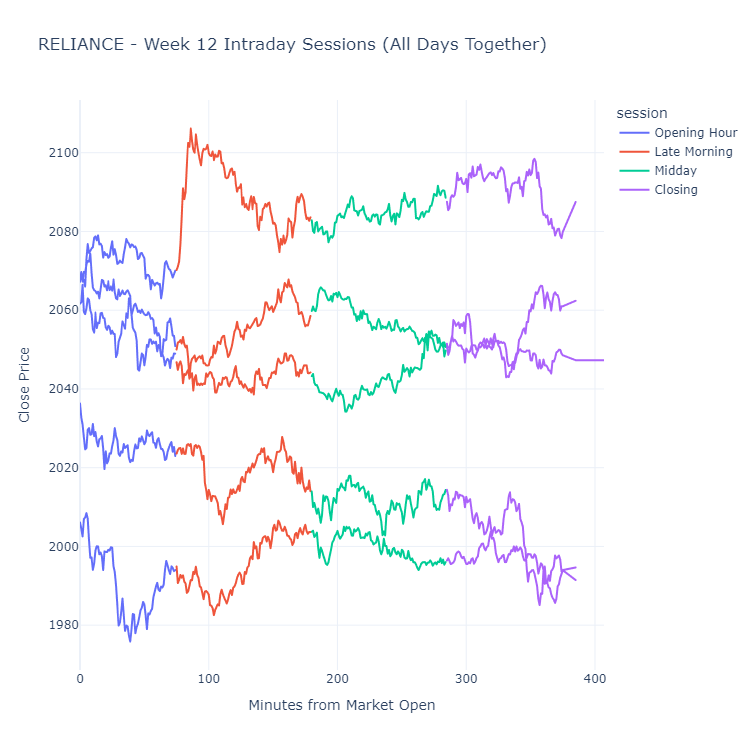

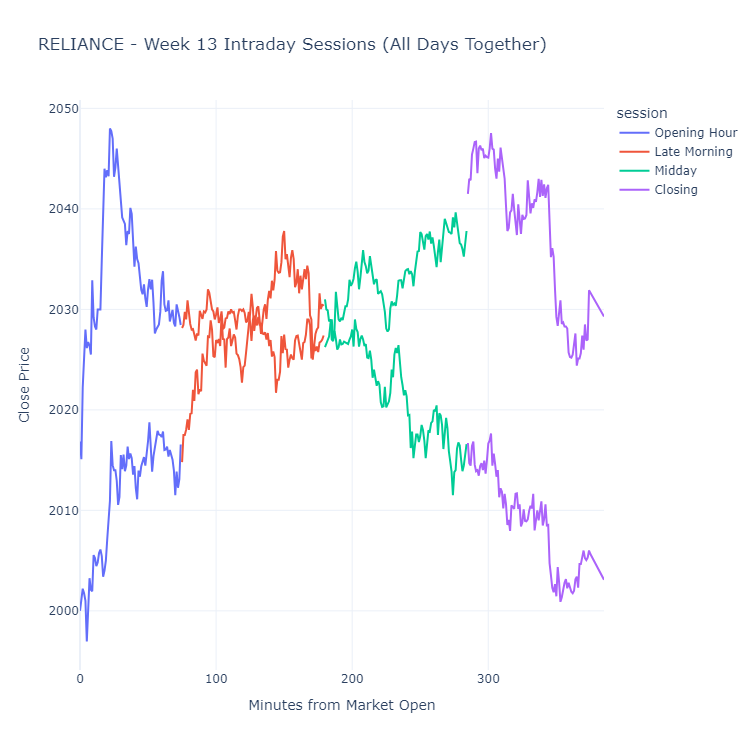

In [6]:
# Extract week and minutes from open
df['week'] = df['datetime'].dt.isocalendar().week
df['day'] = df['datetime'].dt.date
df['minutes_from_open'] = (df['datetime'].dt.hour*60 + df['datetime'].dt.minute) - (9*60 + 15)



# Define 4 sessions
def get_session(minute):
    if minute < 75:   # 09:15–10:30
        return "Opening Hour"
    elif minute < 180:  # 10:30–12:15
        return "Late Morning"
    elif minute < 285:  # 12:15–14:00
        return "Midday"
    else:               # 14:00–15:30
        return "Closing"

df['session'] = df['minutes_from_open'].apply(get_session)

# Example: plot for 1 ticker
ticker = "RELIANCE"
df_ticker = df[df['ticker'] == ticker]

# Loop through each week
weeks = df_ticker['week'].unique()

for w in weeks:
    df_week = df_ticker[df_ticker['week'] == w]

    fig = px.line(
        df_week,
        x="minutes_from_open",
        y="close",
        color="session",       # sessions highlighted
        line_group="day",      # separate lines for each day
        hover_name="day",      # tooltip shows which day
        title=f"{ticker} - Week {w} Intraday Sessions (All Days Together)"
    )

    fig.update_layout(
        width=1300,
        height=750,
        showlegend=True,
        template="plotly_white",
        xaxis_title="Minutes from Market Open",
        yaxis_title="Close Price"
    )

    fig.show()
    # fig.write_html(f"{ticker}_week_{w}.html")

In [7]:
def detect_regimes(data):
    data = data.copy()
    data.set_index('datetime', inplace=True)

    # Log returns
    data['log_return'] = np.log(data['close'] / data['close'].shift(1))

    # Rolling volatility
    data['volatility'] = data['log_return'].rolling(window=15).std() * np.sqrt(15)

    # Rolling slope
    window = 15
    data['slope'] = data['close'].rolling(window).apply(
        lambda x: np.polyfit(range(len(x)), x, 1)[0]
    )

    # Drop NA
    data.dropna(inplace=True)

    # Features
    features = data[['log_return', 'volatility', 'slope']].values
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # HMM model
    hmm_model = GaussianHMM(n_components=2, covariance_type="full", n_iter=1000, random_state=42)
    hmm_model.fit(features_scaled)

    # Predict regimes
    data['regime'] = hmm_model.predict(features_scaled)

    # Label regimes
    regime_stats = data.groupby('regime')[['volatility', 'slope']].mean()
    trending_regime = regime_stats['slope'].abs().idxmax()
    sideways_regime = 1 - trending_regime

    data['regime_label'] = data['regime'].apply(
        lambda x: 'Trending' if x == trending_regime else 'Sideways'
    )

    # Store regime probabilities
    probs = hmm_model.predict_proba(features_scaled)
    data['prob_trending'] = probs[:, trending_regime]
    data['prob_sideways'] = probs[:, sideways_regime]

    return data

In [8]:
# Run regime detection for each ticker
results = []
for ticker, group in df.groupby('ticker'):
    res = detect_regimes(group)
    res['ticker'] = ticker
    results.append(res)

final_df = pd.concat(results)
final_df.reset_index(inplace=True)

In [10]:
final_df.sample(3)

datetime    ticker        date      time    open    high  \
13299  2021-02-22 11:14:00  ADANIENT  2021-02-22  11:14:00   798.5   799.0   
131754 2021-03-10 10:04:00      INFY  2021-03-10  10:04:00  1361.9  1363.1   
179455 2021-03-18 12:28:00  RELIANCE  2021-03-18  12:28:00  2049.1  2049.5   

            low    close  volume  week         day  minutes_from_open  \
13299    798.00   798.40    5202     8  2021-02-22                119   
131754  1361.65  1362.65    9967    10  2021-03-10                 49   
179455  2048.95  2049.30    4632    11  2021-03-18                193   

             session  log_return  volatility     slope  regime regime_label  \
13299   Late Morning   -0.000125    0.004523 -0.087321       0     Sideways   
131754  Opening Hour    0.000771    0.002927 -0.187679       0     Sideways   
179455        Midday    0.000268    0.003348 -0.078929       0     Sideways   

        prob_trending  prob_sideways  
13299        0.000014       0.999986  
131754       0.000063       0.999937  
179455       0.000050       0.999950

In [11]:
summary = final_df.groupby('ticker')['regime_label'].value_counts(normalize=True).unstack().fillna(0) * 100
summary['Dominant Regime'] = summary.apply(lambda x: 'Trending' if x['Trending'] > x['Sideways'] else 'Sideways', axis=1)

print("\nMost Trending Stocks in Q1 2021:")
summary.sort_values('Trending', ascending=False).head(10)



Most Trending Stocks in Q1 2021:


regime_label   Sideways   Trending Dominant Regime
ticker                                            
HINDUNILVR    65.753725  34.246275        Sideways
ADANIENT      68.702625  31.297375        Sideways
RELIANCE      73.652878  26.347122        Sideways
LT            75.242059  24.757941        Sideways
INFY          75.454267  24.545733        Sideways
TCS           76.739806  23.260194        Sideways
BAJFINANCE    77.842502  22.157498        Sideways
ICICIBANK     80.446683  19.553317        Sideways
HDFCBANK      81.677250  18.322750        Sideways
SBIN          99.934340   0.065660        Sideways

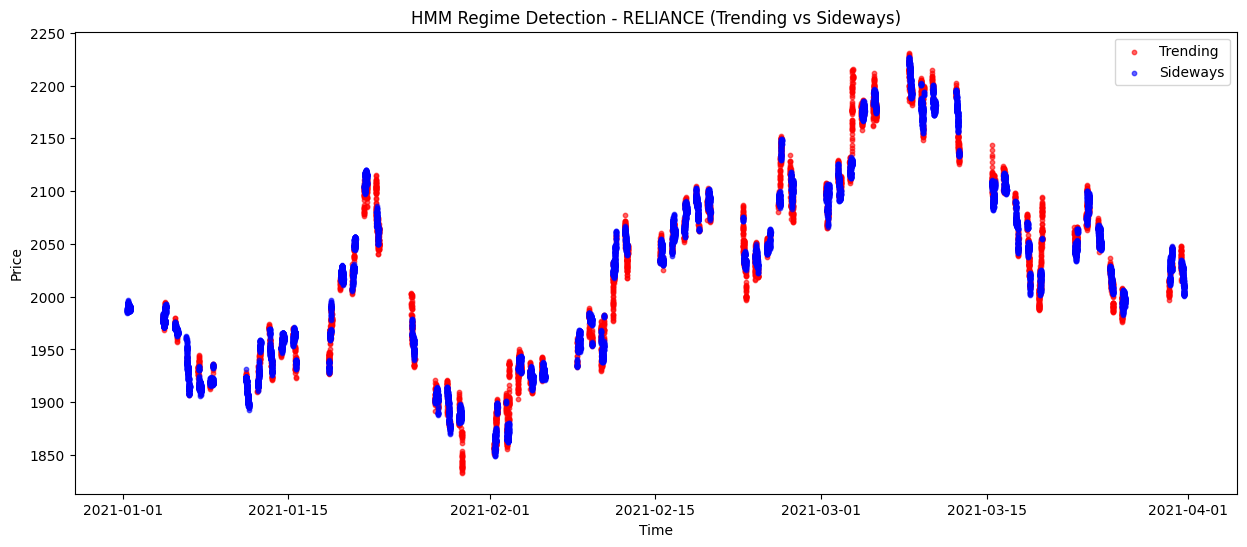

In [12]:
ticker_to_plot = "RELIANCE"  # Change to any ticker in your dataset
plot_df = final_df[final_df['ticker'] == ticker_to_plot]

plt.figure(figsize=(15,6))
for label, color in zip(['Trending', 'Sideways'], ['red', 'blue']):
    mask = plot_df['regime_label'] == label
    plt.scatter(plot_df['datetime'][mask], plot_df['close'][mask], label=label, alpha=0.6, s=10, color=color)

plt.title(f"HMM Regime Detection - {ticker_to_plot} (Trending vs Sideways)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

In [13]:
time_blocks = {
    'Opening Hour': ('09:15:00', '10:30:00'),
    'Late Morning': ('10:30:01', '12:00:00'),
    'Midday': ('12:00:01','14:00:00'),
    'Closing': ('14:00:01', '15:30:00')
}

In [14]:
final_df['time'] = final_df['datetime'].dt.time

# Function to assign time block
def assign_time_block(t):
    t_str = t.strftime('%H:%M:%S')
    for block, (start, end) in time_blocks.items():
        if start <= t_str <= end:
            return block
    return None

In [15]:
final_df['time_block'] = final_df['time'].apply(assign_time_block)


In [16]:
final_df.head(4)

datetime    ticker        date      time    open    high     low  \
0 2021-01-01 09:30:00  ADANIENT  2021-01-01  09:30:00  481.60  482.00  481.60   
1 2021-01-01 09:31:00  ADANIENT  2021-01-01  09:31:00  482.00  482.50  481.25   
2 2021-01-01 09:32:00  ADANIENT  2021-01-01  09:32:00  481.75  482.35  481.75   
3 2021-01-01 09:33:00  ADANIENT  2021-01-01  09:33:00  482.05  482.40  481.30   

    close  volume  week  ... minutes_from_open       session log_return  \
0  481.90    2710    53  ...                15  Opening Hour   0.000000   
1  481.75   22276    53  ...                16  Opening Hour  -0.000311   
2  482.00   12758    53  ...                17  Opening Hour   0.000519   
3  481.45   14597    53  ...                18  Opening Hour  -0.001142   

   volatility     slope  regime  regime_label prob_trending  prob_sideways  \
0    0.004250 -0.031786       0      Sideways  6.445086e-75       1.000000   
1    0.004162 -0.038214       0      Sideways  1.042708e-05       0.999990   
2    0.004103 -0.025893       0      Sideways  1.107709e-05       0.999989   
3    0.004195 -0.035714       0      Sideways  1.683459e-05       0.999983   

     time_block  
0  Opening Hour  
1  Opening Hour  
2  Opening Hour  
3  Opening Hour  

[4 rows x 21 columns]

In [17]:
trend_summary = (
    final_df.groupby(['ticker', 'time_block'])['regime_label']
    .apply(lambda x: (x == 'Trending').mean() * 100)
    .reset_index(name='%_trending')
)


In [18]:
heatmap_data = trend_summary.pivot(index='ticker', columns='time_block', values='%_trending')


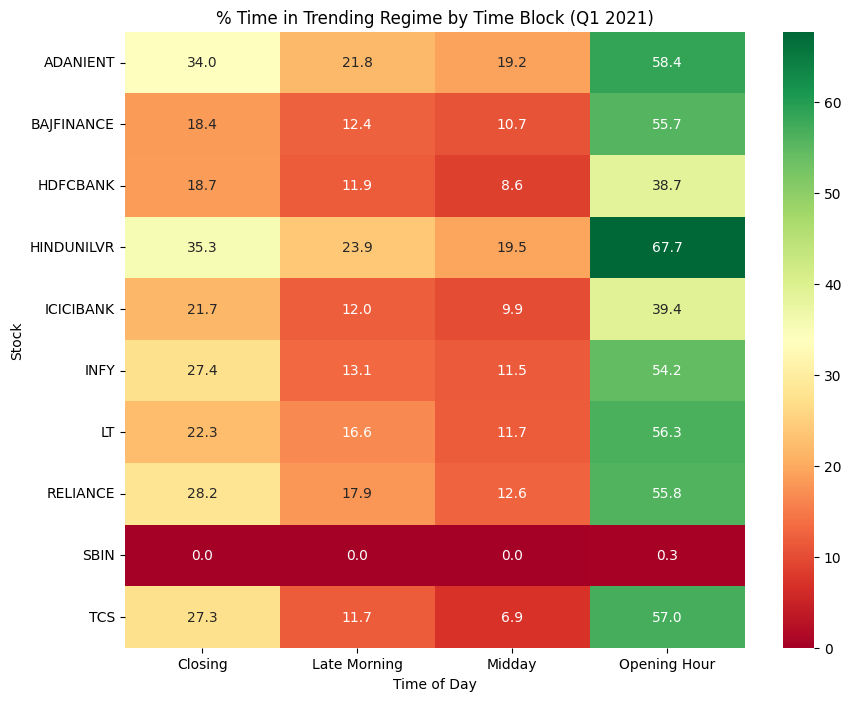

In [19]:
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="RdYlGn")
plt.title("% Time in Trending Regime by Time Block (Q1 2021)")
plt.ylabel("Stock")
plt.xlabel("Time of Day")
plt.show()